In [ ]:
from plotly.offline import init_notebook_mode, iplot_mpl, download_plotlyjs, plot, iplot
import plotly_express as px
import plotly.figure_factory as ff
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
import pandas_profiling
import statsmodels.formula.api as sm
from statsmodels.compat import lzip
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score
from sklearn.metrics import precision_score, roc_auc_score, recall_score, roc_curve, precision_recall_curve
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import graphviz
from sklearn import tree
from sklearn.tree.export import export_text
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import shap
from sklearn.feature_extraction import DictVectorizer
from yellowbrick.classifier import confusion_matrix, classification_report, ROCAUC, DiscriminationThreshold
from yellowbrick.target import ClassBalance, FeatureCorrelation
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.model_selection import CVScores, RFECV, LearningCurve
from sklearn import preprocessing

from pdpbox import pdp, info_plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from yellowbrick.features import RadViz, PCA, pca_decomposition
from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score, silhouette_samples
import catboost
from catboost import CatBoostClassifier, Pool, cv
from time import time

from catboost.utils import get_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

from pdpbox import pdp, get_dataset, info_plots

import lime
import lime.lime_tabular
plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'svg'
# Need to load JS vis in the notebook
shap.initjs()

!pip install ppscore 

import ppscore as pps

******
- author: Xavier Martinez Bartra
- date: December 2020
******

# <a id='#1'>Sloan Digital Sky Survey current DR16 Server: Data release with Galaxies, Stars and Quasars.</a>

## <a id='#1'> Introduction </a>

The Sloan Digital Sky Survey or SDSS is an imagery space research project conducted on a specific 2.5-meter wide-angle telescope located at the Apache Point Observatory in New Mexico (United States). The project aims to map a quarter of the visible sky, obtain observations about 100 million objects and the spectrum of one million objects. The survey includes spectral and photometric information on all detected astronomical objects, including ** stars, galaxies and quasars. **

The Sloan Digital Sky Survey has created one of the most detailed three-dimensional maps of the Universe ever made, with deep, multi-color images of one-third of the sky and spectra for more than three million astronomical objects.

The data is published periodically and publicly. This dataset covers Data Release 16 (DR16) data.

Using the photometric characteristics and the spectroscopic analysis of the redshift we can predict which of the 3 types of celestial objects has been captured by the telescope. An important point to note from the data set is that the classes are not balanced, that is, there are many more stars and galaxies than quasars.

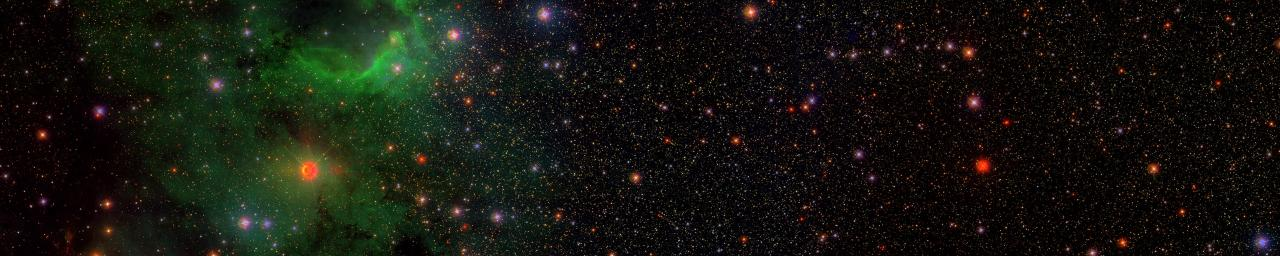

# <a id='#1'> 1. Selection and data preparation </a>

### <a id='#1'> 1.1 DataSet Loading </a>

We only load the first 8,000 observations from the telescope so that we don't have to work with too heavy a data set.

In [ ]:
data=pd.read_csv("../input/sloan-digital-sky-survey-dr16/Skyserver_12_30_2019 4_49_58 PM.csv",nrows=8000)

In [ ]:
df=data.copy()

In [ ]:
df.info()

In [ ]:
df.head()

- The dataset contains 8,000 labeled samples (stars, galaxies, and quasars) and 17 attributes.

- The data set comes from an SQL query that joins two tables:

     - "PhotoObj" which contains photometric data.
     - "SpecObj" which contains spectral data.

- 16 variables (double) and 1 additional variable (char) 'class'.

- An astronomical object can be predicted from the other 16 variable

###  <a id='#1'>Features</a>

- objid = Object Identifier
- ra = J2000 Right Ascension (r-band)
- dec = J2000 Declination (r-band)
- u = better of deV/Exp magnitude fit (u-band)
- g = better of deV/Exp magnitude fit (g-band)
- r = better of deV/Exp magnitude fit (r-band)
- i = better of deV/Exp magnitude fit (i-band)
- z = better of deV/Exp magnitude fit (z-band)
- run = Run Number
- rerun = Rerun Number
- camcol = Camera column
- field = Field number
- specobjid = Object Identifier
- class = object class (galaxy, star or quasar object)
- redshift = Final Redshift
- plate = plate number
- mjd = MJD of observation
- fiberid = fiberID

###  <a id='#1'>Target </a>

- The variable 'class' identifies an object as a galaxy (GALAXY), a star (STAR) or a quasar (QSO).

### <a id='#1'> 1.2 DataSet preparation </a>

We have observed that the DataSet does not contain any null values. Regarding the variables provided, we will only use those that contain some type of intrinsically relevant information about the astronomical objects of class. Therefore, we will only use the photometric ** (u, g, r, i, z,) ** and spectral ** (redshift) ** fields of the objects.

In [ ]:
#We delete the variables which we will not use
df.drop(['objid','run', 'rerun', 'camcol',
       'field', 'specobjid','plate', 'mjd', 'fiberid'],axis=1,inplace=True)

In [ ]:
#We obtain the Dataset with the variables of interest
df.head()

In [ ]:
### 2.1 Separación DataSet entre atributos y target
ps=df[['u','g','r','i','z']]

#Matriz de atributos
X=df[['u','g','r','i','z','redshift']]

#Target 
Y=df['class']

### <a id='#1'> 1.3 Equatorial coordinates of the picture samples </a>

The equatorial coordinate system is the preferred coordinate system for locating objects on the celestial sphere. Unlike the horizontal coordinate system, the equatorial coordinates are independent of the location of the observer and the time of the observation. This means that only one set of coordinates is required for each object, and that these same coordinates can be used by observers at different locations and at different times.

The equatorial coordinate system is basically the projection of the latitude and longitude coordinate system that we use here on Earth, onto the celestial sphere. By direct analogy, latitude lines are converted to declination lines (Dec; measured in degrees, arc minutes, and arc seconds) and indicate how far north or south of the celestial equator (defined by projecting Earth's equator above the celestial sphere) is the object. Lines of longitude have their equivalent in lines of right ascension (RA), but while longitude is measured in degrees, minutes and seconds east of the Greenwich meridian, RA is measured in hours, minutes and seconds east from where the The celestial equator intersects the ecliptic (the vernal equinox).

In [ ]:
fig = px.scatter(df, x='ra',y='dec',color='class',
        title="Equatorial coordinates of the picture samples",
                 color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=0,
        marker_size=8,marker_line_color="black",mode='markers')).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

We observe the equatorial coordinates of the capture of the 8,000 images of the DataSet. We observed some blue spots, which mark regions where only stars were captured.

In [ ]:
#Eliminamos las variables de las coordenadas equatoriales.
df.drop(['ra','dec'],inplace=True, axis=1)

# <a id='#1'> 2. Variable exploratory analysis </a>

### <a id='#1'> SDSS Photometric System (u, g, r, i, z) </a>

In astronomy, a photometric system is a set of optical filters with a known sensitivity to incident radiation. Sensitivity generally depends on the optical system, detectors and filters used.

Each photometric letter designates a particular section of the electromagnetic spectrum.

     "U" stands for ultraviolet.
     "G" stands for green.
     "B" stands for blue.
     "I" stands for infrared.
     "Z" stands for near-infrared.

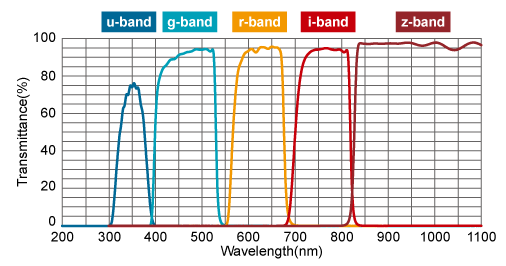

### <a id='#1'> Red Shift </a>

In astronomy, the  "Red Shift" study is a study of a section of the sky to measure the redshift of astronomical objects such as galaxies, galaxy clusters, stars, or quasars. Thus, using Hubble's law, the "Red Shift" can be used to estimate the distance of an object from Earth. By combining redshift with angular position data, a redshift study maps the 3D distribution of matter within a field of the sky. These observations are used to measure detailed statistical properties of the large-scale structure of the universe and can also be used to aid discrimination between astronomical objects such as stars, galaxies, and quasars.

Generally, the construction of a redshift study involves two phases: first images of the selected area of ​​the sky are taken with a wide-field telescope, then galaxies brighter than a defined boundary are selected from the resulting images as non-point objects.

Second, the selected galaxies are observed using spectroscopy, most commonly at visible wavelengths, to measure the wavelengths of prominent spectral lines; By comparing the observed and laboratory wavelengths, the redshift is obtained for each object.

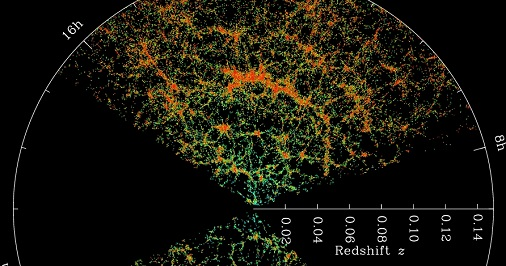

### <a id='#1'> Astronomical Class </a>

- **Star:** A star is a luminous plasma spheroid that maintains its shape thanks to its own gravity.

- **Galaxy:** A galaxy is a set of stars, gas clouds, planets, cosmic dust, dark matter and energy gravitationally bound together in a more or less defined structure.

- **Quasar** (acronym for "quasi-stellar radio source", translation from English quasi-stellar radio source) is an astronomical source of electromagnetic energy, which includes radio frequencies and visible light.

### <a id='#1'> 2.1 Pandas Profile Report </a>

With the Pandas Profile Report method we get a complete statistical exploration of our DataFrame.

In [ ]:
pandas_profiling.ProfileReport(df)

The report warns us that there are several variables with high levels of correlation. We also observe that the redshift distribution is very asymmetric. After this first examination of the data, we proceed to analyze the variables in detail.

### <a id='#1'>2.2 Astrononomical class </a>

In [ ]:
fig = px.pie(Y, 'class', title='Astronomical class - pie chart distribution', 
             color_discrete_sequence=px.colors.qualitative.Safe).update_traces(hoverinfo='label+value', 
  textinfo='percent', textfont_size=16,
).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')
fig.show()

This set of data presents a clear imbalance in the number of observations that we have for each class. Only 10.9% of the observations are quasars. Galaxies and stars are more balanced. When proposing our predictive algorithm we must take this casuistry into account in order not to generate a biased model.

### <a id='#1'>2.3 Redshift distribution  </a>

In [ ]:
df.redshift.describe()

We observe that 25% of the observations have a value less than -0.000033.

In [ ]:
fig = px.histogram(df, marginal='box', x="redshift",log_y=True,nbins=30,
title='Histogram - Redshift log count',
             template='ggplot2',color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1, marker_line_color="black")).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

To better visualize the distribution we use a histogram with the count in logarithmic scale. We find a very asymmetric distribution to the left in which the value of the third quartile corresponds to only 0.093 redshift.

In [ ]:
px.histogram(df, marginal='box',x="redshift",nbins=30,log_y=True,color='class',
             title="Histogram & Box Plots - Log escale count redshift per class",template='ggplot2',facet_col='class',
             color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1,
   marker_line_color="black")).update_traces(dict(marker_line_width=1, 
             marker_line_color="black")).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',plot_bgcolor='rgb(243, 243, 243)')

- We observe that the Box-Plot values of the redshift of the stars are so low compared to the quasars that they are not even visualized in the figure. All stars are in the first bin of the histogram [-0.1 0.1]


- Galaxies have a slightly higher redshift than stars, but much lower than quasars. There is a galaxy with a redshift = 1.08, but more than 99% of the galaxies have a redshift <0.3


- On a logarithmic scale, we observe how the vast majority of the high values of the redshift correspond to quasars. In the first bin [-0.1 0.1] there are only 17 quasars.

### <a id='#1'> 2.4 Distributions Photometric System (u, g, r, i, z) </a>

We analyze the distributions of the photometric variables.

In [ ]:
melt = pd.concat([Y,ps],axis=1)

melt = pd.concat([Y,ps],axis=1)
melt = pd.melt(melt,id_vars="class",
                    var_name="Photometric System",
                    value_name='value')

fig = px.box(melt, x="Photometric System",y='value',title='Box plots - Photometric System (u, g, r, i, z)',
             color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1, 
marker_line_color="black")).update_layout( paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')
fig.show()

We observe that only r, i and z have outlier values beyond the third quartile of their distribution. In general, we find quite asymmetric distributions with many outlier values. If necessary, we could carry out transformations with logarithms to have more normalized distributions.

In [ ]:
fig = px.box(melt, x="Photometric System",y='value',color='class',title='Box plots - Photometric System (u, g, r, i, z) by class',
             color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1, marker_line_color="black")).update_layout( paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')
fig.show()

Regarding the distribution of the photometric variables by target, we observe how the ccasars tend to have higher values in all the predictors.

### <a id='#1'> 2.4 Correlation matrix of photometric attributes and Red shift </a>

In [ ]:
fig = px.imshow(X.corr(),x=list(X.corr().columns),y=list(X.corr().columns),
                width=900, height=500,title='Correlation Matrix Photometric system (u,g,r,i,z) & red shift',
                color_continuous_scale=px.colors.sequential.PuBuGn).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')
fig.show()

- 0 We observe that the photometric variables are highly positively correlated with each other, especially (g, r, i, z), with correlations higher or close to 0.9. The u variable for ultraviolet light seems to have a more moderate correlation with the rest of the photometric variables.


- The redshift is also moderately positively correlated with the photometric variables (values of 0.4 approx.) And very weakly with u.

# <a id='#1'> 3. Clustering </a>

Although we have a data set already classified (each observation has one of the 3 astronomical classes assigned), we can explore how the data set responds with unsupervised clustering algorithms and if it is possible to find different groupings to the three astronomical objects of the DataSet.

The objective is to be able to generate cohesive groups and, at the same time, very different from each other in order to obtain groups with high intragroup similarity and low intergroup similarity.

In [ ]:
#Target label encoder
le = preprocessing.LabelEncoder()
le.fit(Y)
Y=le.transform(Y)
df['target']=Y

### <a id='#1'> 3.1 Clustering with K-means </a>

To carry out the Elbow method (we execute n = k iterations, increasing the value of K in each iteration and record the inertia (or sum of squared errors or distance of each point from its centroid). In the figure we observe that as k increases, the distortion decreases. This is because as more centroids are included, the distance from each point to its closest centroid decreases. The algorithm detects the optimal point (where the inertia curve begins to bend.) ak = 3, so having 3 groups matches the three types of astronomical objects.

The value k is chosen by striking a reasonable balance between inertia and a coherent grouping.

### <a id='#1'>3.1.1 Elbow method </a>

In [ ]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1,12), size=(3400, 1500))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The distortion falls off rapidly when Kmeans reaches k = 3, but from there, it begins to decrease more slowly and its decrease becomes less significant.

### <a id='#1'> 3.1.2 Silhouette Plot </a>

In the following figure we have the Silhouette Plot of the 3 clusters that we have selected:

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick',size=(3700, 1500))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The silhouette coefficient is a metric of the cohesion and separation of the groups. It measures how well an observation is doing in your group based on two factors:

 How close it is to the other observations in the group.
 How far it is from the rest of the observations of the other groups.

The silhouette coefficient values ​​vary between -1 and 1.

- A coefficient close to +1 means that the instance is within its own cluster and away from other groups.
- A coefficient close to 0 means that it is close to another group.
- A coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

The silhouette coefficient of each cluster is the mean of all the observations in a score.

The silhouette coefficient of each observation =
a (b - a) / max (a, b)

where a is the mean distance to the other observations in the same group (that is, the intragroup mean distribution) and b is the mean distance to the closest group.

We observe that cluster 0 is the one with the observations with the highest coefficient, which means that it has the highest cohesion as a cluster and is relatively relatively far from other groups.

### <a id='#1'> 3.1.3 KMeans Intercluster Distance Map </a>

This figure shows us in a reduced dimensional space the distance between the centroids of the 3 clusters using a multidimensional scale. How close or far the centers are in the visualization is derived from how close / far they are in the original data space. The size of the clusters is scaled by the number of instances that belong to each center, a fact that gives us an idea of the relative importance of each cluster.

In [ ]:
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(model,size=(3700, 1500))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

We observe that cluster 0 (the one with the highest mean of the Silhouette score) is the one that is represented with more instances near its center.

### <a id='#1'> 3.1.4 Principal Component Plot: Kmeans = 3 </a>

With PCA we can visually examine the distribution of the 3 clusters found. We can also compare the distribution of clusters with astronomical objects.

In [ ]:
clus_pred = model.fit_predict(X)
df['KMcluster']=clus_pred

visualizer = PCA(scale=True, proj_features=True,size=(3000, 2000),alpha=0.50,random_state=1)
visualizer.fit_transform(X, clus_pred)
visualizer.show()

We observe that the three clusters found have a clear separability with PCA. With PCA we project the directions of maximum variability of the original attributes, which help us to interpret the clusters obtained.

Clusters interpretation:
    
- Cluster 0: photometric variable mean values.
    
- Cluster 1: Low values of redshift and photometric variables.

- Cluster 2: Higher redshift values and photometric variables except ultraviolet.

We can examine the 2-D distribution of astronomical objects with PCA to compare the distribution of objects in 2-d space with the three clusters of the k-means algorithm.

In [ ]:
visualizer = PCA(scale=True, classes=le.classes_, proj_features=True,size=(3000, 2000),alpha=0.50)
visualizer.fit_transform(X, Y)
visualizer.show()

Although it appears that cluster 1 of k means roughly matches the cuasar class, since both have high redshift values and photometric attributes, the relationship of the clusters to stars and galaxies is much more diffuse.

# <a id='#1'> 4. PCA dimensionality reduction of photometric predictors </a>

We have detected very high levels of correlation between the photometric variables, so these variables are an ideal target to perform dimensionality reduction with PCA. The dimensionality reduction will help us to better visualize the relationships between the photometric data and the redshift for each type of astronomical object and to have fewer uncorrelated variables for predictive modeling.

In [ ]:
# we will perform PCA with the 5 photometric variables
ps.head()

In [ ]:
visualizer = PCA(scale=True, classes=le.classes_, proj_features=True,size=(3000, 2000),alpha=0.5)
visualizer.fit_transform(ps, Y)
visualizer.show()

- We observe the projections of maximum variability of the data for each of the photometric variables. The quasars are in the projection area of the variables z, i, r.

- We also observe that there is a group of stars separated from the main group with high values of the variables z, i r.

In [ ]:
# We scale our Matrix (DataSet) First we transform our DF in a scaled Matrix (scaled by the μ and σ of each columm) 
df_=scale(ps)

In [ ]:
# from sklearn we import PCA module and we fit our DataSet, we specify the number of PC and call the fit() method 

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_)


# Now we can transform our DataSet
df_2d = pca.transform(df_)

# We generate a new Dataframe with our two components as variables
df_2d = pd.DataFrame(df_2d)
df_2d.columns = ['PC1',"PC2"]

In [ ]:
df_2d.head()

With the explained_variance_ratio method we will calculate the variance ratio of our PCs to know the total variance that they collect. As we know with PCA we find, in the data space, the dimensions with the greatest variation of the general variation of the data. In short, PCA replaces the original variables with new variables, called principal components, that are orthogonal (have zero covariations) and have variances (called eigenvalues) in decreasing order.

In [ ]:
# We compute the explained variance ratio
DataFrame(pca.explained_variance_ratio_.round(2), index=['PC'+str(i) for i in range(1,3)], 
          columns=['Explained Variance Ratio']).T

The first PC explains 88% of the overall variance, while the second represents 11%. The very high value of the first component is an indication of the high correlation between our variables. Thus, using both main components (and reducing it from 5 variables to 2) let us absorb 99% of the explanatory power of the data.

In [ ]:
df['PC1']=df_2d.PC1
df['PC2']=df_2d.PC2

In [ ]:
fig = px.scatter_matrix(df,
    dimensions=["PC1", "PC2", "redshift"],
    color="class",                                    
    title="Scatter matrix of photometric PC1 & PC2 and RedShift by class",
    labels={col:col.replace('_', ' ') for col in df.columns},color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1, marker_line_color="black")).update_layout( paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)').update_traces(diagonal_visible=False)

fig.show()

- Examining the scatter plot Matrix of the PCs and the redshift we deduce that having a high redshift seems a very important indicator when it comes to identifying quasars.


- The relationship between PC1 and PC2 is more difficult to visualize with the naked eye, but it seems that stars tend to have a high PC2, and galaxies a high PCA1.

In [ ]:
fig=px.scatter_3d(df, x='PC2',y='PC1',z='redshift',title="Photometric scatter plot PC1 & PC2 per class",
        color='class',color_discrete_sequence=px.colors.qualitative.Safe).update_traces(marker_size=5).update_layout( paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

In the visualization PC1, PC2 with the redshift, we observe that the values with high redshift almost all caseres. Stars tend to have high PC2 values

### <a id='#1'> 4.1 PCA interpretation </a>

In [ ]:
fig = px.imshow(df[['u','g','r','i','z','PC1','PC2']].corr(),x=list(df[['u','g','r','i','z','PC1','PC2']].corr().columns),y=list(df[['u','g','r','i','z','PC1','PC2']].corr().columns),
                width=900, height=500,title='Correlation Matrix Photometric system (u,g,r,i,z) & PC1 PC2',
                color_continuous_scale=px.colors.diverging.BrBG).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')
fig.show()

** PC1, PC2 interpretation: **

- PC1: it is negatively correlated with all photometric elements, especially (g, r, i, z).


- PC2: this component is more difficult to interpret. It is positively correlated with z, i and r and negatively with g. It is strongly negatively correlated with u.

# <a id='#1'> 5. Predictor dependencies by target class </a>

In this section we will examine all the dependencies and relationships of the predictors by target class.

### <a id='#1'> 5.1 Predictor dependencies by target class </a>

RadViz is a multivariate data visualization algorithm that plots each attribute uniformly around the circumference of a circle and then plots points inside the circle such that the point normalizes its values on the axes from the center to each arc. This mechanism allows as many dimensions as can easily fit in a circle, expanding the dimensionality of the display. It gives us an idea of the separability between classes.

In [ ]:
# Instantiate the visualizer
visualizer = RadViz(classes=le.classes_,size=(3800, 2000),alpha=0.05)

visualizer.fit(X, Y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()

We observe how the quasars are projected onto the redshift. While the stars have a greater projection towards i and u. We also see a blue fringe of the galaxies projecting a bit onto the g.

### <a id='#1'> 5.2 Mutual Info-classification </a>

This figure details the mutual information of each attribute with the target. Mutual information measures the reduction of uncertainty for one variable given a known value of another. The mutual information between two random variables X and Y can be formally established as follows:

     I (X; Y) = H (X) - H (X | Y)

Where I (X; Y) is the mutual information for X and Y, H (X) is the entropy for X and H (X | Y) is the conditional entropy for X given Y.

Mutual information is a measure of dependency or "mutual dependency" between two random variables. As such, the measure is symmetric, which means that I (X, Y) = I (Y, X). Measures the average reduction in uncertainty about x that results from learning the value of y; or vice versa, the average amount of information that x conveys about y.

In [ ]:
# Instaniate the visualizer
visualizer = FeatureCorrelation(
    method='mutual_info-classification', feature_names=X.columns.tolist(), sort=True,
size=(3600, 2000))

visualizer.fit(X, Y)        # Fit the data to the visualizer
visualizer.show()    

The attribute that has the most mutual information with the target is the redshift by far from the others. The ultraviolet is the one that has less mutual information with the target. The other 4 variables have a similar mutual information with the target of over 20%.

### <a id='#1'> 5.3 Predictive Power Score PPS </a>

Predictive Power Score or PPS is a data type agnostic and asymmetric metric that helps identify linear or nonlinear relationships between two variables in a data set. The spectrum of PPS values ​​is between 0 (no predictive power) and 1 (highest predictive power). Through PPS we can find out how useful a variable will be to predict the values ​​of another variable. Unlike the study of correlations, using decision trees the PPS can discover non-linear relationships between different columns that cannot be obtained from the correlation and can also handle categorical data. Also, unlike the correlation matrix, the PPS is asymmetric. This means that if variable A can predict the values ​​of variable B, it does not mean that column B can also predict the values ​​of column A, and PPS will show this interpretation.

If the task is ranking, we calculate the weighted F1 score (wF1) as the underlying evaluation metric (F1_model). As the F-1 score achieved is relative, a baseline score is computed for each prediction from a model that always predicts the most common class in the case of classification and the median prediction value in the case of regression.

The PPS is the result of the following normalization (always> = 0):

PPS = (F1_model - F1_naive) / (1 - F1_naive)

If the method used is regression, the mean absolute error (MAE) evaluation metric is used. Again, in this case as well, we first calculate "MAE for naive model" and then, using this score, we generate the desired MAE for the predictive power score.

Here the score is between 0 and 1, but since this score tells us about the error component, the lower it is, the better it is. The mathematical formula used to calculate the MAE is mentioned below.
PPS = 1 - (MAE_model / MAE_naive)

Source: https://github.com/8080labs/ppscore

In [ ]:
p=X.copy()
p['y']=df['class']

predictors=pps.predictors(p, "y")

fig = px.bar(predictors, x="x", y='ppscore',
              title="Bar Plot - Predictive power score atributes with target",
              color_discrete_sequence=px.colors.qualitative.Pastel2).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

This figure shows us the predictive power score of all the attributes. In the line of the mutual information figure, we observe that the redshift is the attribute that has a very high score, close to 1. This metric attributes greater predictive power to variable z than to i. The PPS coincides with the MI that u is the variable with the lowest predictive power.

Source text
116 / 5000
Translation results
### <a id='#1'> 5.4 PPS Matrix </a>

This table gives us the PPS between all the variables in the data set.

In [ ]:
pps.matrix(p)

We can observe many relevant relationships. For example, while the redshift has a PPS of 0.96 with the target, the target has a PPS of 0.50 with the redshift. The photometric variables have a predictive power of 0 on the redshift.

### <a id='#1'> 5.5 Grouping by target class </a>

Using the Groupby method we can perform additional groupings such as sum (), mean (), median (), min () and max () according to various criteria. With this methodology we can obtain very complex insights about our data from different casuistry.

**Grouping por class: Variables fotométricas**

In [ ]:
df1=df.groupby('class').aggregate(['mean','median','max','min','std'])
df1.iloc[:,:25].T

This table gives us all the statistical data of each photometric variable for each of the astronomical objects.

In [ ]:
aux=df.groupby('class').aggregate('mean')
gz=aux[['u','g','r','i','z']].T
gz['photometric variable']=gz.index

fig = px.scatter(gz, x='photometric variable',y=['GALAXY','QSO','STAR'],
        title="Mean values for each photometric variable (u,g,r,iz) per class ",
                 color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1,
        marker_size=16,marker_line_color="black",mode='markers+lines')).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

In this figure we can observe the different mean values of each photometric variable for each astronomical object.

- We observe that in all the photometric bands, the quasars have higher mean values, although the difference in ultraviolet is not very high.

- Galaxies and stars have very similar mean values in all variables, but in u i and z there is a divergence that can be key to predicting classes.

**Grouping por class: Redshift**

In [ ]:
df1.iloc[:,25:30].T

This table has the statistical data of the redshift for each of the astronomical objects. We observe that the mean value of the stars is negative. In the case of the redshift we see that the caseres have an average redshift of 1.26 and the galaxies 0.077. In the case of stars, the maximum value of the redshift is 0.004153.

In [ ]:
# We transform discrete variables into dummy variables
df ['GALAXY'] = pd.get_dummies (df ['target']). iloc [:, 0: 1]
# We transform discrete variables into dummy variables
df ['QSO'] = pd.get_dummies (df ['target']). iloc [:, 1: 2]
# We transform discrete variables into dummy variables
df ['STAR'] = pd.get_dummies (df ['target']). iloc [:, 2: 3]


fig, axes, summary_df = info_plots.target_plot (
     df = df, feature = 'redshift', feature_name = 'redshift', target = ['GALAXY'], num_grid_points = 10, ncols = 1,
figsize = (11, 7))

We observe that within the interval [0.03-0.18) almost all objects are galaxies. While only 0.073% of galaxies fall into the last bin of [0.18-5.46]

In [ ]:

fig, axes, summary_df = info_plots.target_plot(
    df=df, feature='redshift', feature_name='redshift', target=['QSO'],num_grid_points=10,ncols=1,
figsize=(11, 7))

92.7% of the quasars have a redshift between [0.18-5.46]

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=df, feature='redshift', feature_name='redshift', target=['STAR'],num_grid_points=10,ncols=1,
figsize=(11, 7))

We observe how all stars have a redshift <0.03.

# <a id='#1'> 6. Feature Engineering </a>

In data exploration we have examined the relationships and dependencies of the photometric and redshift variables with the different astronomical objects. Using the insights obtained we will create new variables that can help us to have more predictors and build more powerful predictive models.

### <a id='#1'> 6.1 Redshift discretization </a>


We have observed that the Redshift has a very asymmetric right distribution with many small values and a few high values. The logarithmic transformation of the variable would give us a more normal and less asymmetric distribution, but the Redshift finds some negative values, which does not allow us to carry out the transformation.

Yes, we can discretize the variable according to the value intervals that cut each quartile. We have observed that the reshdift is a very important variable when it comes to differentiating astronomical objects.

In [ ]:
pd.cut(df['redshift'], bins=df['redshift'].quantile([.0,.25, .5, .75, 1.])).value_counts()

These are the quartile intervals for the redshift.

In [ ]:
df['reds_dis']=pd.cut(df['redshift'], bins=df['redshift'].quantile([.0,.25, .5, .75, 1.]),labels=['q1',"q2","q3","q4"])

### <a id='#1'> 6.2 Discretization of the mean of the photometric variables (u, g, r, i, z) </a>
We can generate a new variable that collects the average of the five photometric variables.

In [ ]:
df['m_pho']=(df.u+df.g+df.r+df.i+df.z)/5

We also discretize the variable with its quartiles.

In [ ]:
pd.cut(df['m_pho'], bins=df['m_pho'].quantile([.0,.25, .5, .75, 1.])).value_counts()

These are the quarties intervals for the mean of the photometric variables.

In [ ]:
df['m_pho']=pd.cut(df['m_pho'], bins=df['m_pho'].quantile([.0,.25, .5, .75, 1.]),labels=["q1","q2","q3","q4"])

### <a id='#1'> 6.3 Examining PPS variables </a>

Using a PPS we can examine the predictive power attributed to the new variables.

In [ ]:
p['reds_dis']=df['reds_dis']
p['m_pho']=df['m_pho']
predictors=pps.predictors(p, "y")

In [ ]:
predictors.iloc[1:2,:]

We observe that the redshift discrete variable has a moderately high PPS, but much lower than the original variable.

In [ ]:
predictors.iloc[6:7,:]

The discrete variable of the mean of the photometric values has a very low value, so it is highly probable that it is a variable of little use to build a robust predictive model.

### <a id='#1'> 6.4 Creation of predictor matrices </a>

We create 4 matrices that we will use iteratively to train our best predictive model. We will use the matrix X of predictors that offers us better predictive power.

**Final feature engineering assessment after training the model with cross-validation:**

- Thanks to the insights obtained in our exploratory data analysis, we have obtained a comprehensive understanding of our variables and their relationship with the target. CatBoost models have been generated with 3 different predictor matrices. (X_1, X_2 and X_3).


- The discretization of the redshift variable and the construction of the m_pho variable do not increase the predictive power of the model in the validation set. (model with matrix of predictors X_2).


- Thanks to the insights obtained in the structural analysis of the model, it has been inferred that the interactions of "redshift" with "g" and with "i". (model with predictors X_3) had explanatory power over the target. The implementation of these interactions, however, has not improved the predictive power of the model. (loss of score F1 quasars).


- The matrix X_1 of original predictors constructs the model with the best predictive capacity and also allows us a more direct interpretation of the behavior of the model.


In [ ]:
X_1=df[['u', 'g', 'r', 'i', 'z','redshift']]

X_2=X_1.copy()
X_2['reds_dis']=df.reds_dis
X_2['m_pho']=df.m_pho

X_3=X_1.copy()
X_3['redshift*g']=X['redshift']*X['g']
X_3['redshift*i']=X['redshift']*X['i']

X_pca=df[['redshift']]
X_pca['PC1']=df_2d['PC1']
X_pca['PC2']=df_2d['PC2']

Y=df['class']

In [ ]:
X_1.head(2)

In [ ]:
X_2.head(2)

In [ ]:
X_3.head(2)

In [ ]:
X_pca.head(2)

# <a id='#1'> 7. CatBoost Classifier </a>

We will create a predictor model with CatBoost, a decision tree Gradient boosting algorithm. This algorithm generates a very robust predictive model in the form of a set of weak decision trees. It builds the model in a stepwise fashion like other boosting methods do, and generalizes them allowing arbitrary optimization of a differentiable loss function. For more information see:

https://catboost.ai/news/catboost-enables-fast-gradient-boosting-on-decision-trees-using-gpus

Gradient boosting with decision trees is a form of machine learning that works by progressively training more complex models to maximize the accuracy of predictions. The algorithm minimizes a cost function by iteratively choosing towards the negative gradient.

In [ ]:
#We prepare the data so that the algorithm can process categorical attributes
categorical_features_indices = np.where(X.dtypes != np.float)[0]

## <a id='#1'> 7.1 CatBoost with feature matrix X </a>

In [ ]:
#predictor matrix
X_1.head()

### <a id='#1'> 7.1.1 Split your data into train and validation </a>

We keep 20% of the observations as validation set (out of sample data) to be able to predict with samples not used in training and to have an estimate of the errors. With the stratify = y method, we make sure that the two data sets have the same pore per class as the original data set.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_1, Y, test_size=0.2, random_state=0, stratify=Y)

### <a id='#1'> 7.1.2 Creating the train and validation Pool </a>

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validation_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

###  <a id='#1'> 7.1.3 Train the model </a>

In [ ]:
model = CatBoostClassifier(iterations=500,  random_seed=42, custom_loss=['F1','Accuracy','AUC'], early_stopping_rounds=50)

model.fit(train_pool, eval_set=validation_pool, verbose=25, plot=True)

In [ ]:
print(model.get_best_iteration())

We train the model with 500 iterations validating the data with the validation set. From the properties of the DataSet and our predictors, the model establishes a learning rate of 0.146031. Using the validation set with the training of the data, the algorithm selects the number of trees that minimize the cost function.

In the log we can see how the learning error and the test or validation error decrease with each iteration (generation of new trees), as the model learns with the data. After 100 iterations, the model progressively has fewer errors in the validaton set. The model begins to overfit when the number of iterations increases but the number of validation errors does not decrease or begins to increase. As we have selected early_stopping_rounds = 50, the model stops when 50 iterations pass without reducing the errors of the validaton set.

 The model obtains the lowest errors with 420 trees. From here the model begins to overfit the training data.

In [ ]:
#The model has obtained the least errors with selected 420 trees
model.tree_count_

###  <a id='#1'> 7.1.4 Cross-validation evaluation </a>

The Cross-Validation function randomly divides the training set into K distinct subsets and
train and evaluate the decision tree model k times, choosing a different subset for
evaluation each time and training in the other k fold subsets. We will divide the data set into 10 subsets (k = 3).

In [ ]:
cv_params = model.get_params()

cv_params.update({
    'loss_function': 'MultiClass',
    'iterations': 1000,
    'custom_loss':['F1','Accuracy','AUC']})

cv_data = cv(train_pool, cv_params, shuffle=True,fold_count=3, plot=True, verbose=50, stratified=True)

We observe that after 400 iterations, the marginal improvement of the model errors begins to decline.

In [ ]:
cv_data.tail(5)

The error that we observe at each iteration is the mean of the errors of each fold (of the 3 total) of each iteration of the cross-validation.

### <a id='#1'> 7.1.5 Model evaluation: Confusion matrix and Classification Report </a>

We analyze the classificatory performance of our model by examining the Matrix confusion and the recall and precision of the model. The confusion matrix gives us the false negatives (lower left value) and false positives (upper right value). Correctly classified values ​​are on the main diagonal. (class 0 as 0 and class 1 as 1)

<a id='#1'> PRECISION </a>

Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. False positives are instances that the model incorrectly labels "churn" when they are actually negative. It expresses the proportion of the data points that our model says are relevant when in fact they were relevant.

<a id='#1'> RECALL </a>

The recall is the number of true positives divided by the number of true positives plus the number of false negatives. True positives are data points classified as positive by the model that are actually positive (correct), and false negatives are data points that the model identifies as negative that are actually positive (incorrect). In the case of churn, the true positives are customers who left credit card services and are correctly identified, and the false negatives would be individuals labeled "no churn" by the model, but who actually dropped out. It expresses the ability to find all relevant instances in a data set.

<a id='#1'> F1-SCORE </a>

In some situations, we may want to maximize recall or precision at the expense of the other metric. In the case that we are trying to "churn" customers, we can accept a lower precision if we can obtain a higher recall (we want to find many customers who intend to abandon credit card services)

However, in cases where we want to find an optimal combination of precision and recall, we can combine the two metrics using what is called an F1 score.

The F1 score is the harmonic mean of precision and recall taking into account both metrics. The harmonic mean is used instead of a simple average because it punishes extreme values.

<a id='#1'> CONFUSION MATRIX </a>

The confusion matrix gives us the false negatives and false positives of each class. Correctly classified values are on the main diagonal.

In [ ]:
y_pred=model.predict(X_val)
cm=confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ["GALAXY", "QSO", "STAR"], 
                     columns = ["GALAXY", "QSO", "STAR"])

plt.figure(figsize=(13,6))
sns.heatmap(cm_df, annot=True,fmt='.4g',cmap="YlGnBu")
plt.title('CatBoost classifier\nAccuracy:{0:.3f}'.format(accuracy_score(y_val, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

We note that there are two stars that have been incorrectly classified as Galaxies and 6 galaxies that have been classified as stars. In relation to the quasars, the model erroneously predicts 7 quasars as Galaxies and one galaxy incorrectly classified as Cuasar.

In [ ]:
#Create classification report
print(classification_report(y_pred,y_val))

The model obtains very high scores in all classes with the validation set. The lowest score is the precision of the quasars.

### <a id='#1'> 7.1.6 Predictions </a>

The model allows us to make predictions about new instances.

In [ ]:
model.predict(X_val)

El método predict_proba de scikit learn nos permite obtener las probabilidades de que la observación sea de una clase determinada. 

In [ ]:
model.predict_proba(X_val).round(3)

##  <a id='#1'> 7.2 CatBoost with PCA </a>

We build the CatBoost model using the matrix with PCA components.

In [ ]:
X_pca.head()

In [ ]:
#Split data into train and validation
X_pca_train, X_pca_val, y_pca_train, y_pca_val = train_test_split(X_pca, Y, test_size=0.2, random_state=0, stratify=Y)

train_pool_pca = Pool(X_pca_train, y_pca_train)
validation_pool_pca = Pool(X_pca_val, y_pca_val)

###  <a id='#1'> 7.2.1 Train the model with PCA </a>

In [ ]:
model_pca = CatBoostClassifier(iterations=500,  random_seed=42, custom_loss=['F1','Accuracy','AUC'], early_stopping_rounds=50)

model_pca.fit(train_pool_pca, eval_set=validation_pool_pca, verbose=25, plot=True)

In [ ]:
#The model has selected 150 trees
model_pca.tree_count_

After 150 trees, the ensemble has started to overfit and the number of errors with the validation set does not decrease; that is, the algorithm stops when adding 50 additional trees does not reduce the number of errors with the validation set.

### <a id='#1'> 7.2.2 Confusion matrix and Classification Report </a>

In [ ]:
y_pca_pred=model_pca.predict(X_pca_val)

In [ ]:
cm=confusion_matrix(y_val, y_pca_pred)
cm_df = pd.DataFrame(cm,
                     index = ["GALAXY", "QSO", "STAR"], 
                     columns = ["GALAXY", "QSO", "STAR"])

plt.figure(figsize=(13,6))
sns.heatmap(cm_df, annot=True,fmt='.4g',cmap="YlGnBu")
plt.title('PCA Catboost classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_val, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#Create classification report
class_report=classification_report(y_pca_pred, y_pca_val)
print(class_report)

- With PCA we obtain results that are quite similar to the original data set, but with less precision when detecting quasars.


- By having some main components that collect 99% of the explanatory power of the original data of the photometric variables, the predictive power of the PCA model remains robust.


- If we are interested in having to work with fewer variables to have greater computational flexibility in training the model, we can have a model with good predictive capacity.


- The disadvantage of working with PCA is that the interpretability of the model is much more complex, since it is difficult to correctly interpret what the PCA variables mean.

# <a id='#1'> 8. Model analysis </a>

In this section we will analyze the structural behavior of our model with the best score. We are going to examine its structural interpretability, both from the point of view of the importance / contribution of its predictors and the interpretative casuistry of its predictions.

## <a id='#1'> 8.1 Partial dependency plots

Partial dependency graphs show the dependency between the target class and an attribute, removing the effects of all other attributes. These graphs can show if the relationship between the target class is linear, monotonous, ... In short, they help us better understand the dependencies between the attributes of our model and the target class. To compute these graphs, we predict the probability of the target class with new data, but changing the values of the variable before making a prediction. Thus, we first predict the class probability for the different values that the attribute takes and then we plot how the probability of the target class changes for the different values that the attribute takes.

We analyze the partial dependency plot of the redshift and the photometric metrics with the three astronomical objects. The area on the curve shows us the confidence interval with the standard deviation.
    
The y value of the figures shows us the relative contribution of the predictor on each class.

- Positive values mean a positive contribution by the mentioned class, by the values of the predictor.
- Values 0 mean an absence of effect on the mentioned class by the predictor values
- Negative values mean a negative contribution of the predictor on the mentioned class, due to the predictor values.

In [ ]:
model.classes_

- Clase 0: GALAXY
- Clase 1: QSO
- Clase 2: STAR

In [ ]:
# Create the data that we will plot
pdp_redshift= pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns,
                                    feature='redshift',num_grid_points=1000)

fig, axes = pdp.pdp_plot(pdp_redshift,'redshift',figsize=(12, 7), center=True,ncols=3,plot_params = {
            # pdp line color, highlight color and line width
            'pdp_color': 'coral',
            'pdp_hl_color': 'coral',
            'pdp_linewidth': 2,
            # horizon zero line color and with
            'zero_color': '#E75438',
            'zero_linewidth': 1,
            # pdp std fill color and alpha
            'fill_color': 'coral',
            'fill_alpha': 0.2,
            # marker size for pdp line
            'markersize': 3,
        })
plt.show() 

- In the partial dependence plot of the Galaxy redshift we observe that when the redshift is between 0-0.15 the probability that the object is a galaxy is pushed up to 1. From here the effect begins to decrease to practically 0 from a redshift of 1.5.


- In the case of quasars, after a redshift> 0.1 approx, the probability that the object is a quasar increases progressively, being more than 90% from 1.5 to the end.


- In the case of stars, the redshift causes a huge drop in class probability.

In [ ]:
# Create the data that we will plot
pdp_redshift= pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns,
                                    feature='u',num_grid_points=100)

fig, axes = pdp.pdp_plot(pdp_redshift,'u',figsize=(12, 7),
                         ncols=3, 
)
plt.show() 

- The ultraviolet has a positive effect on the probability that the object is a galaxy from u> 18.

- The positive effect detected on the galacians turns into a negative effect on the quasars (to a similar magnitude).

- The effect detected on the stars is almost null. It seems that at certain values between 18 and 20 the impulse is positively negative and others close to 0 or positive.

In [ ]:
# Create the data that we will plot
pdp_redshift= pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns,
                                    feature='g',num_grid_points=1000)

fig, axes = pdp.pdp_plot(pdp_redshift,'g',figsize=(12, 7), 
                         ncols=3, frac_to_plot=1, 
)
plt.show() 

The effect of i is very low for all classes; but it slightly boosts the probability that the object is a galaxy or a star and lowers the probability that it is a cuasar (but in very small magnitudes)

In [ ]:
# Create the data that we will plot
pdp_redshift= pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns,
                                    feature='z',num_grid_points=1000)

fig, axes = pdp.pdp_plot(pdp_redshift,'z',figsize=(12, 7), 
                         ncols=3, frac_to_plot=1, 
)
plt.show() 

We observe the same logic as in predictor i. Although the effects are very small, it seems to have somewhat positive effect for galaxies and stars and somewhat negative for quasars.

In [ ]:
# Create the data that we will plot
pdp_redshift= pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns,
                                    feature='r',num_grid_points=1000)

fig, axes = pdp.pdp_plot(pdp_redshift,'r',figsize=(12, 7), 
                         ncols=3, frac_to_plot=1, 
)
plt.show() 

The effect of r is also quite low for all classes; but the probability that the object is a galaxy decreases slightly and the probability that it is a cuasar increases. It has practically no effect on the stars.

In [ ]:
# Create the data that we will plot
pdp_redshift= pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns,
                                    feature='g',num_grid_points=1000)

fig, axes = pdp.pdp_plot(pdp_redshift,'g',figsize=(12, 7), 
                         ncols=3, frac_to_plot=1, 
)
plt.show() 

The effect of g is similar to that of r, in relation to galaxies and quasars, but slightly negative for stars.

## <a id='#1'> 8.2 Feature importances </a>

In this section we will analyze the importance that the model attributes to predictors from different perspectives.

### <a id='#1'> 8.2.1 Prediction Values Change </a>

For each predictor, the PredictionValuesChange shows how much the prediction changes on average if the value of the attribute changes. The greater the importance value, the greater the change in the prediction value on average, if this predictor is changed. The importance values of the characteristics are normalized so that the sum of the importances of all the characteristics equals 100.

In [ ]:
ax=model.get_feature_importance(type='PredictionValuesChange',prettified=True)

fig = px.bar(ax, x='Feature Id',y=['Importances'],
              title="Cat Boost predictors importance - Prediction value change",
              color_discrete_sequence=px.colors.qualitative.Prism).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

We observe that modifying the redshift value, the model predictions vary by 77%. We observed that the ultraviolet, which obtained the score in the PPS and Mutual information has the second highest score.

### <a id='#1'> 8.2.2 Loss Function Change </a>

For each predictor, the value represents the difference between the cost function of the model with and without this attribute. The model without this attribute is equivalent to what would have been trained if this attribute were excluded from the dataset. Since it is computationally expensive to retrain the model without one of the predictors, this model is roughly constructed using the original model with this predictor removed from all trees in the set. Calculating this importance requires a data set, and therefore the calculated value depends on the data set.

In [ ]:
ax=model.get_feature_importance(train_pool, type='LossFunctionChange',prettified=True)

fig = px.bar(ax, x='Feature Id',y=['Importances'],
              title="Cat Boost predictors importance - Loss Function Change",
              color_discrete_sequence=px.colors.qualitative.Vivid).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

From this point of view of the cost function of the model, the redshift also represents the most important variable.

### <a id='#1'> 8.2.3 Feature Interaction </a>

We proceed to analyze the strength of the interactions between predictors for each pair. All partitions of the predictor pair of the model ensemble are examined to calculate the interaction between attributes. If there are divisions of both characteristics in the tree, then we are seeing how much the value of the leaf changes when the divisions have the same value and when they have opposite values.

In [ ]:
fi = model.get_feature_importance(train_pool,type="Interaction", prettified=True)
fi['First Feature Index'].replace({0:'u',1:'g',2:"r",3:"i",4:"z",5:"redshift",6:"reds",7:"m_pho"},inplace=True)
fi['Second Feature Index'].replace({0:'u',1:'g',2:"r",3:"i",4:"z",5:"redshift",6:"reds",7:"m_pho"},inplace=True)

fi['feature-interaction']=fi['First Feature Index']+"-"+fi['Second Feature Index']

fig = px.bar(fi, x='feature-interaction',y=['Interaction'],
              title="Cat Boost predictors importance- Feature interaction",
   color_discrete_sequence=px.colors.qualitative.Dark24).update_layout( 
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')

fig.show()

We observe that the model attributes the most important interaction to g-redshift.

# <a id='#1'> 9. Model interpretability with Shapley Additive explanations (SHAP) </a>

The Sahpley Additive explanations are game theory approach to explain the result of any machine learning model. Tree SHAP allows us to give an explanation of the behavior of the model, in particular of how each attribute impacts the predictions of the model. Each outcome / prediction is viewed as a sum of the contribution of each individual attribute.

The idea behind SHAP is to provide interpretability to machine learning models.

- Global interpretability seeks to understand the general structure of the model. This involves doing a study on how the model works in general, not just on a specific prediction.

- The local interpretability of the models consists in providing detailed explanations of why an individual prediction was made. This helps stakeholders to trust the model and know how to integrate its recommendations with other decision factors.

### <a id='#1'> 9.1.1 Global interpretability with Summary plot </a>

This figure gives us a huge amount of information about the structure of the model. In the figure we can find:

- Most important attribute of the model on the y-axis in descending order (at the top, the most important).

- The SHAP value of the observations on the x-axis and shows whether the effect of that value caused a higher or lower prediction.

- The value of each attribute with colors. A high value is represented by red, while a low value is represented by blue.

- Each point represents a result of a prediction.

<a id='#1'> Summary plot para clase GALAXY </a>

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values[0],X_val,alpha=0.5)

- The redshift is the variable that is most important according to the value of its SHAP values.

- We observe how there are many observations with low redshift values that have a strong impact on the prediction of Galaxies and values with high redshift almost all have a negative impact on the prediction of Galaxies. There are many observations with low low redshift that also had a negative impact on the prediction of galaxies, so having low redshift does not seem like a very suitable predictor when identifying galaxies.

- Having high ultraviolet values seems a fairly reliable characteristic when classifying galaxies.

<a id='#1'> Summary plot para clase QSO </a>

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values[1], X_val,alpha=0.5)

- High values of redshift is an essential characteristic when predicting quasars.

- Having high ultraviolet values lowers the probability that an object is a stone

- High values of g increase the probability that the object is a cuasar

<a id='#1'> Summary plot para clase STAR </a>

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values[2], X_val,alpha=0.5)

- Many low redshift values have a positive impact on the prediction of the stars, but there are also many stars with low redshift values whose impact on the model prediction was negative.

- High values of g tend to have a negative impact on the prediction of stars and high values of z and i have a positive impact.

### <a id='#1'> 9.1.2 SHAP Dependence Contribution Plots </a>

Previously, we used Partial Dependency Plots to show how a single characteristic affects predictions. These are revealing and relevant to many real world use cases, but there is a lot of information that you don't see, for example what is the distribution of effects? Is the effect of having a certain value fairly constant or does it vary greatly depending on the values of other characteristics? Shap dependency contribution plots give us a similar view to PDPs, but add much more detail.


Each point represents a row of data. The horizontal location is the actual value of the data set, and the vertical location shows the impact that value had on the prediction. We observe a spread between many observations (vertical separation between observations that had the same redshift). This indicates that there are other predictors that interact with the redshift and that influence the impact of the prediction. Color coding helps us interpret the impact of these interactions

### <a id='#1'> SHAP Dependence Contribution Plots Redshift-G </a>

We will examine the dependence of the redshift contribution on the variable g (the variable that has obtained the highest score in the ranking of interactions) for each astronomical object.

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_val)

# make plot.
shap.dependence_plot("redshift", shap_values=shap_values[0],interaction_index="g",
                     features=X_val,title='GALAXY Dependence Contribution Plot redshift-g')

We observe a totally decreasing trend from redshift> 0.1; when the redshift is close to zero. We see some blue points in the lower band of the shap value that also represent observations that have a low value of g. These observations drive the model to lower the probability of predicting that the object is a galazia.

In [ ]:
shap.dependence_plot("redshift", shap_values=shap_values[1],interaction_index="g",
                     features=X_val,title='QSO Dependence Contribution Plot redshift-g')

With the quasar class the redshift relation is increasing, but from 0.5, the momentum of probability that the observation is a quasar has little marginal increase. We observe that observations with low values of green tend to drive the possibility that an object is a stone.

In [ ]:
# make plot.
shap.dependence_plot("redshift", shap_values=shap_values[2],interaction_index="g",
                     features=X_val,title='STAR Dependence Contribution Plot redshift-g')

In the case of stars, we observe that practically all values> 0 tend to lower the probability that the object is a star. In the case of the green, it seems that high green values somewhat boost the probability that an object is a star given the same redshift.

### <a id='#1'> SHAP Dependence Contribution Plots g-r </a>
We now examine the interaction of g and r, the interaction of photometric variables that Catboost has detected with greater importance

In [ ]:
# make plot.
shap.dependence_plot("g", shap_values=shap_values[0],interaction_index="r",
                     features=X_val,title='GALAXY Dependence Contribution Plot g-r')

We observe that high values of g tend to be associated with high values of r. While observations with low values of g and r have little or no contribution to galaxies, most observations with both high values have a negative shap contribution.

In [ ]:
# make plot.
shap.dependence_plot("g", shap_values=shap_values[1],interaction_index="r",
                     features=X_val,title='QSO Dependence Contribution Plot g-r')

In the case of quasars, we can observe a very definite positive relationship (in PDPs we have detected that these predictors had a similar behavior with quasars. As both values rise, the greater the positive effect on the quasars.

In [ ]:
# make plot.
shap.dependence_plot("g", shap_values=shap_values[2],interaction_index="r",
                     features=X_val,title='STAR Dependence Contribution Plot g-r')

In relation to stars, the dynamics are similar to those of galaxies, but even more defined.

### <a id='#1'> 9.1.3 Validation Set Force Plots </a>

In the following figures we have all the observations of the validaton set for each of the astronomical objects. For all the observations, we can examine the effect of each of the predictors on the impact that the object is of the mentioned class.

<a id='#1'> Force plot X_val for GALAXY </a>

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_val)

# visualize the validation set predictions
# load JS visualization code to notebook
shap.force_plot(explainer.expected_value[0], shap_values[0], X_val)

<a id='#1'> Force plot X_val for QSO </a>

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val)

<a id='#1'> Force plot X_val for STAR </a>

In [ ]:
shap.force_plot(explainer.expected_value[2], shap_values[2], X_val)

We observe the same interpretive logic as in the other figures.

- Redshift values around 0 drive the probability that the object is a star.
- Values between 0.046-0.20 of approx redshift drive the probability that the object is a galaxy.
- Redshift values> 0.077 impose the probability that the object is a cuasar.

### <a id='#1'> 9.2 Local interpretability </a>

We can break down individual predictions to show the impact of each attribute of the model on it. This casuistry is tremendously useful to make our predictions more interpretable. SHAP values do this in a way that guarantees a very important property. Specifically, we decompose a prediction with the following equation:

sum (SHAP values for all attributes) = pred_for_instance - pred_for_baseline_values

### <a id='#1'> 9.2.1 Decision / Force plots </a>

In [ ]:
explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = explainer.shap_values(X_val.iloc[0,:])

We observe, for example, how the model predicts observation 522 of the validation set that corresponds to a Galaxy.

In [ ]:
j=522
print("Object is a: ",y_val.iloc[j])
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_val.iloc[j,:])

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val.iloc[j,:])

The value of the redshift has been the one that has prompted the model to predict that it is a galaxy. If we interpret the same observation for the star class or when we obtain the opposite result.

In [ ]:
j=522
print("Object is a: ",y_val.iloc[j])
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_val.iloc[j,:])

### <a id='#1'> 9.2.2 Visualize multioutput predictions </a>

Decision graphs can show how classificatory models arrive at predictions by showing the shap values obtained by all classes. For instance j = 522, we can see the model traversal for each attribute and class.

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_val)

j=522
shap.multioutput_decision_plot(explainer.expected_value, shap_values,  feature_names=X_val.columns.tolist(),
                               row_index=j,legend_labels=list(model.classes_),
                               legend_location='lower right')   

We can also visualize and explain decisions about multiple predictions and the direction of their impact. In the following figures we have all the predictions of the validation set for each of the classes. The default visualization shows some interesting decisions about model prediction patterns.

# <a id='#1'> 10. Model interpretability with Local Interpretable Model-agnostic Explanations (LIME) </a>

LIME is a novel algorithm designed by Riberio Marco, Singh Sameer, Guestrin Carlos to access the behavior of the estimator of any base (model) using local interpretable surrogate models (for example, linear classifier / regressor). This form of comprehensive assessment helps to generate explanations that are locally accurate but may not align with global behavior. Basically, the LIME explanations are based on local surrogate models. These surrogate models are interpretable models (such as a linear model or a decision tree) that are learned about the predictions of the original model. But instead of trying to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why unique predictions have been made.

 LIME typically generates a new data set that consists of disturbed samples and the predictions of the associated black box model. On this data set, LIME then trains an interpretable model weighted by the proximity of the sampled instances to the instance of interest. Below is a standard high-level workflow for this.

- Choose your instance of interest for which you want to have an explanation of the predictions of your black box model.
- Disturb your data set and get the original model predictions for these new points.
- Weight the new samples by their proximity to the instance of interest.
- Fit a weighted and interpretable (surrogate) model in the data set with the variations.
- Explain the prediction by interpreting the local model.

By default, Lime uses Ridge Regression as its interpretable linear model.

In [ ]:
predict_fn = lambda x: model.predict_proba(x).astype(float)
X_ = X_train.values

explainer = lime.lime_tabular.LimeTabularExplainer(X_, feature_names = X_train.columns.tolist(),
                                                  class_names=['GALAXY',"QSO",'STAR'])

In [ ]:
j=531
print("Real class:",y_val.iloc[j])
choosen_instance = X_val.iloc[[j]].values[0]

exp = explainer.explain_instance(choosen_instance, predict_fn,top_labels=1)

exp.show_in_notebook(show_table=True, show_all=False)

*Interpretation instance 531 of the Validation set.*

The prediction seems to be logical considering the high value of the redshift. (1.98) (In the PDP we have seen that when the redshift increased by 1.5, the probability that the object is a cuasar was more than 90%. Although the ultraviolet value of this object is greater than 19.28, the probability that it is a cuasar has decreased somewhat, the high value of the redshift makes the model decide that the probability that it is a cuasar is 100%.

In [ ]:
j=855
print("Real class:",y_val.iloc[j])
choosen_instance = X_val.iloc[[j]].values[0]

exp = explainer.explain_instance(choosen_instance, predict_fn,top_labels=1)

exp.show_in_notebook(show_table=True, show_all=True)

*Interpretation instance 855 of the Validation set.*

This object was detected with negative redshift values, so it seems logical that the model almost certainly opted for it to be a star. The value of g g> 18.07 is the only predictor that makes the model fall for the probability that it is not a star.

# <a id='#1'> 11. Conclusions </a>

In this project, a data set (8,000 observations) has been selected, corresponding to spectral and photometric information on the capture of three types of astronomical objects: stars, galaxies and quasars. The data set collects photometric information from five optical bands (u, g, r, i z) and a spectroscopic study (red shift) of the astronomical objects produced by the study of images obtained by the telescope.

The statistical properties and the relationships, interactions and dependencies between the predictors and the target variable have been examined from multiple perspectives. A clustering of the data set has been carried out using K-means. The dimensionality of photometric attributes with PCA has been reduced. 

By doing a split of 80%-20% of the data set (training-validation), a predictive model has been generated with the Gradient Boosting Catboost algorithm; achieving a high predictive capacity on the validation data. After analyzing the predictive capacity of the model with different combinations of predictor attributes, it was determined that the matrix of predictors without linear transformations (without reduction in PCA dimensionality) and without discretization offers the highest predictive power over the validation data (fewer errors). We have obtained a model with general accuracy of 99% and F1 scores of 0.99 for the GALAXY class, 0.98 for the QSO class and 0.99 for STAR. The model allows us to make predictions about new observations captured by the telescope with high reliability.

Finally, the structural behavior of the model has been interpreted from different points of view, both from the global interpretative point of view, and in relation to the predictions of specific instances.